In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')


doc = nlp("The 22-year-old recently won ATP Challenger tournament.")


for tok in doc:
  print(tok.text, "...", tok.dep_, spacy.explain(tok.dep_))

The ... det determiner
22-year ... compound compound
- ... punct punctuation
old ... nsubj nominal subject
recently ... advmod adverbial modifier
won ... ROOT None
ATP ... compound compound
Challenger ... compound compound
tournament ... dobj direct object
. ... punct punctuation


In [8]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')


from spacy.matcher import Matcher 
from spacy.tokens import Span 


import networkx as nx


import matplotlib.pyplot as plt
from tqdm import tqdm


pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [9]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [10]:
candidate_sentences['sentence'].sample(5)

3600                                                             bloody disgusting gave the movie
3356                      many renowned directors were involved in developing iranian war cinema:
4296                                                     eggers merely directs us to look inside.
3557               el angel  is a 2018 argentine-spanish true crime film directed by luis ortega.
663     the bbfc is also the designated regulator for the forthcoming uk age-verification scheme.
Name: sentence, dtype: object

In [13]:
doc = nlp(" eggers merely directs us to look inside")


for tok in doc:
  print(tok.text, "...", tok.dep_, spacy.explain(tok.dep_))

  ...  None
eggers ... nsubj nominal subject
merely ... advmod adverbial modifier
directs ... ROOT None
us ... dobj direct object
to ... aux auxiliary
look ... xcomp open clausal complement
inside ... advmod adverbial modifier


In [28]:
def get_entities(sent):
 ## chunk 1
 # 我在这个块中定义了一些空变量。prv tok dep和prv tok text将分别保留句子中前一个单词和前一个单词本身的依赖标签。前缀和修饰符将保存与主题或对象相关的文本。
    ent1 = ""
    ent2 = ""


    prv_tok_dep = "" # dependency tag of previous token in the sentence
    prv_tok_text = "" # previous token in the sentence


    prefix = ""
    modifier = ""


 #############################################################
 
    for tok in nlp(sent):
 ## chunk 2
 # 接下来，我们将遍历句子中的记号。我们将首先检查标记是否为标点符号。如果是，那么我们将忽略它并转移到下一个令牌。如果标记是复合单词的一部分(dependency tag = compound)，我们将把它保存在prefix变量中。复合词是由多个单词组成一个具有新含义的单词(例如“Football Stadium”, “animal lover”)。
 # 当我们在句子中遇到主语或宾语时，我们会加上这个前缀。我们将对修饰语做同样的事情，例如“nice shirt”, “big house”


 # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
 # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
 # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
 
 # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
 # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
 
 ## chunk 3
 # 在这里，如果令牌是主语，那么它将作为ent1变量中的第一个实体被捕获。变量如前缀，修饰符，prv tok dep，和prv tok文本将被重置。
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = "" 


 ## chunk 4
 # 在这里，如果令牌是宾语，那么它将被捕获为ent2变量中的第二个实体。变量，如前缀，修饰符，prv tok dep，和prv tok文本将再次被重置。
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
 
 ## chunk 5  
 # 一旦我们捕获了句子中的主语和宾语，我们将更新前面的标记和它的依赖标记。
 # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
 #############################################################


    return [ent1.strip(), ent2.strip()]

In [29]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [30]:
entity_pairs = []


for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))




entity_pairs[10:20]

100%|███████████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:26<00:00, 160.16it/s]


[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'telepath selene gallio'],
 ['singer', 'sequel']]

In [32]:
# entity_pairs

In [35]:
#抽提句子关系，，V
def get_relation(sent):


    doc = nlp(sent)


 # Matcher class object 
    matcher = Matcher(nlp.vocab)


 #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 


    matcher.add("matching_1", None, pattern) 


    matches = matcher(doc)
    k = len(matches) - 1


    span = doc[matches[k][1]:matches[k][2]] 


    return(span.text)

In [36]:
get_relation("John completed the task")

'completed'

In [37]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


pd.Series(relations).value_counts()[:50]

100%|███████████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:25<00:00, 171.67it/s]


is               372
was              302
released on       88
are               74
include           72
were              67
released          42
's                39
composed by       35
have              31
became            31
has               30
become            28
released in       27
included          25
called            21
had               21
considered        20
made              20
produced          19
been              19
used              18
scheduled         17
be                16
written by        15
received          15
stars             14
produced by       14
hired             14
wrote             14
introduced in     13
went              13
wanted            12
directed by       12
began             11
won               11
began in          11
gave              10
features          10
set               10
sold              10
reported           9
produced in        9
used in            9
includes           9
opened             9
cast as            9
said         

In [38]:
# extract subject
source = [i[0] for i in entity_pairs] 
# extract object
target = [i[1] for i in entity_pairs] 


kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations}) 

In [40]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())  

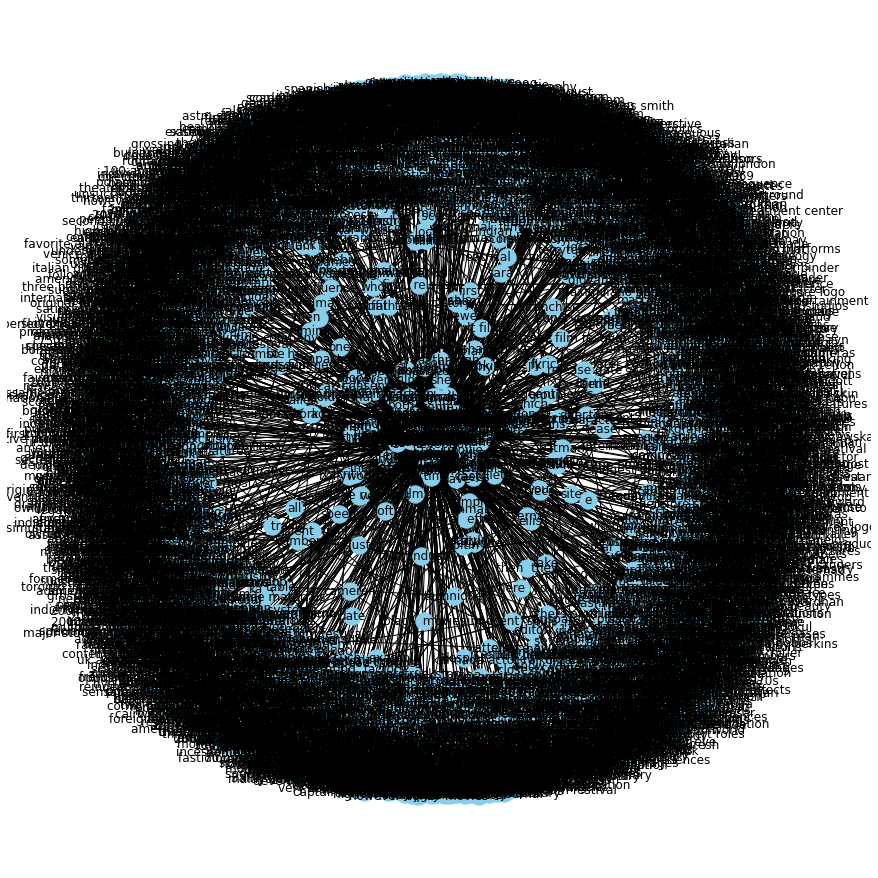

In [41]:
plt.figure(figsize=(12,12))


pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

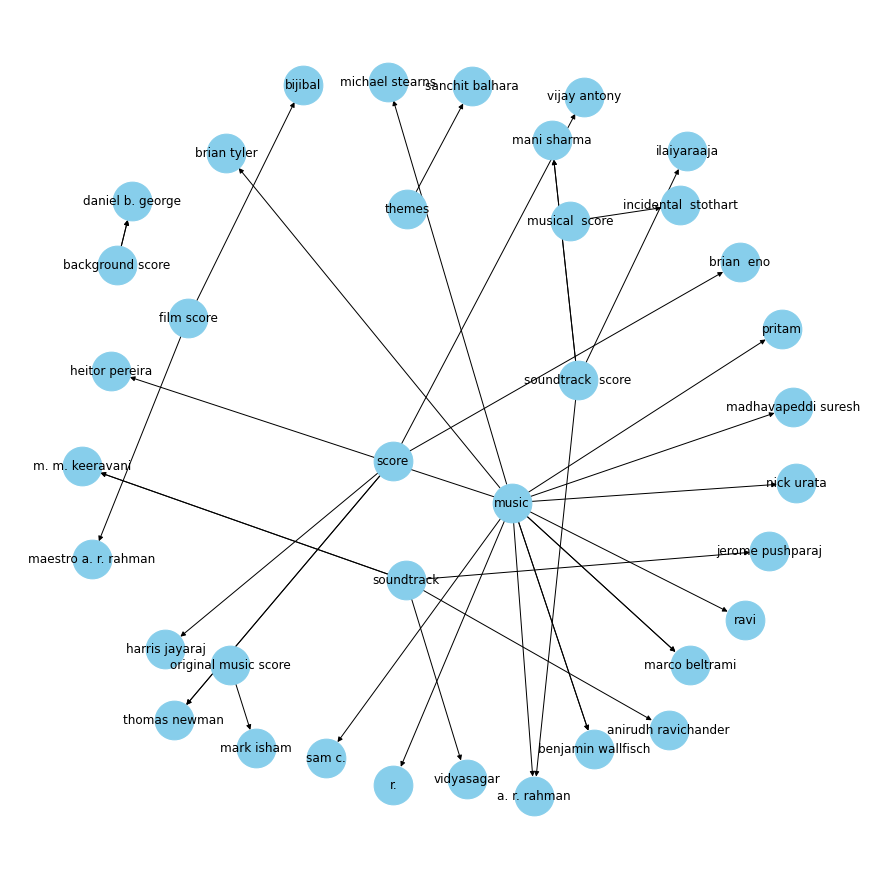

In [42]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

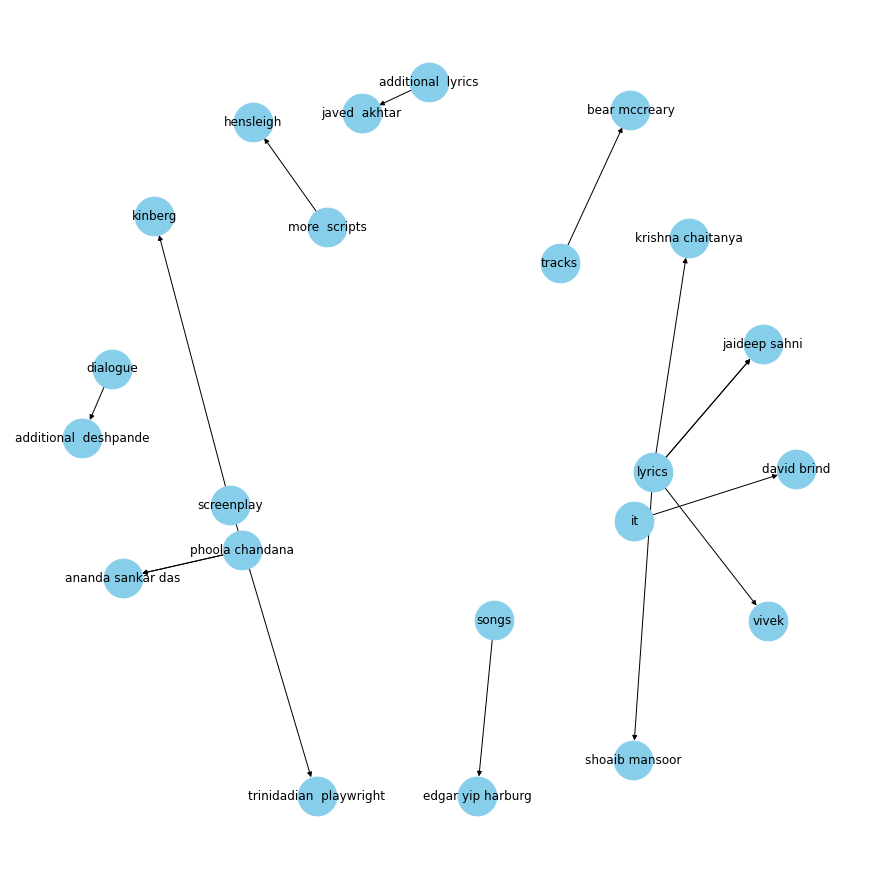

In [43]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()